<a href="https://colab.research.google.com/github/mbertani/conformal-prediction/blob/main/00_Tutorial_theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agenda

1. Why is uncertainty quantification important
2. What is conformal prediciton
3. Examples
4. Follow more examples in the other notebooks in this repository

# 1. Why conformal prediction



## 1.1 Motivating example

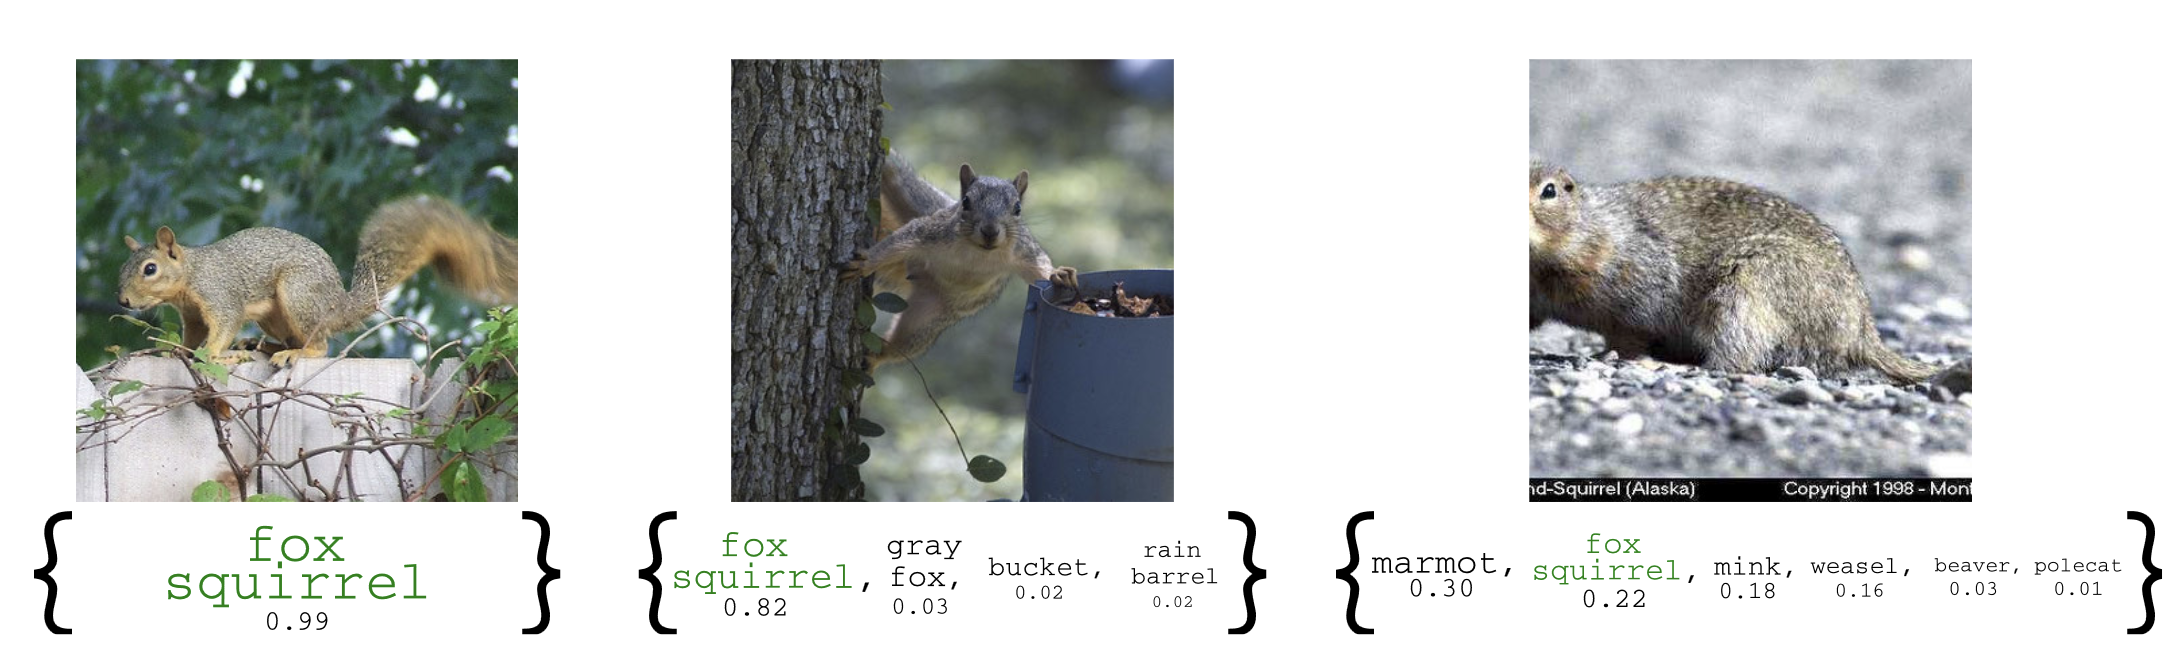


### Why do we need uncertainty estimation?

1. ML predictors usually generate point estimates
2. A softmax function is applied at the end to generate "probability scores"
3. No level of confidence on the prediction is given
4. Most uncertainty methods are model-specific by design
5. Calibration of models is often not enough

<img src = "https://blog.dataiku.com/hs-fs/hubfs/conformal%20pred.png?width=1200&name=conformal%20pred.png">

That is, samples with **predicted probability p** should have an observed **frequency** of belonging to the positive class to be **precisely p**.

## 1.2 Calibration not enough?

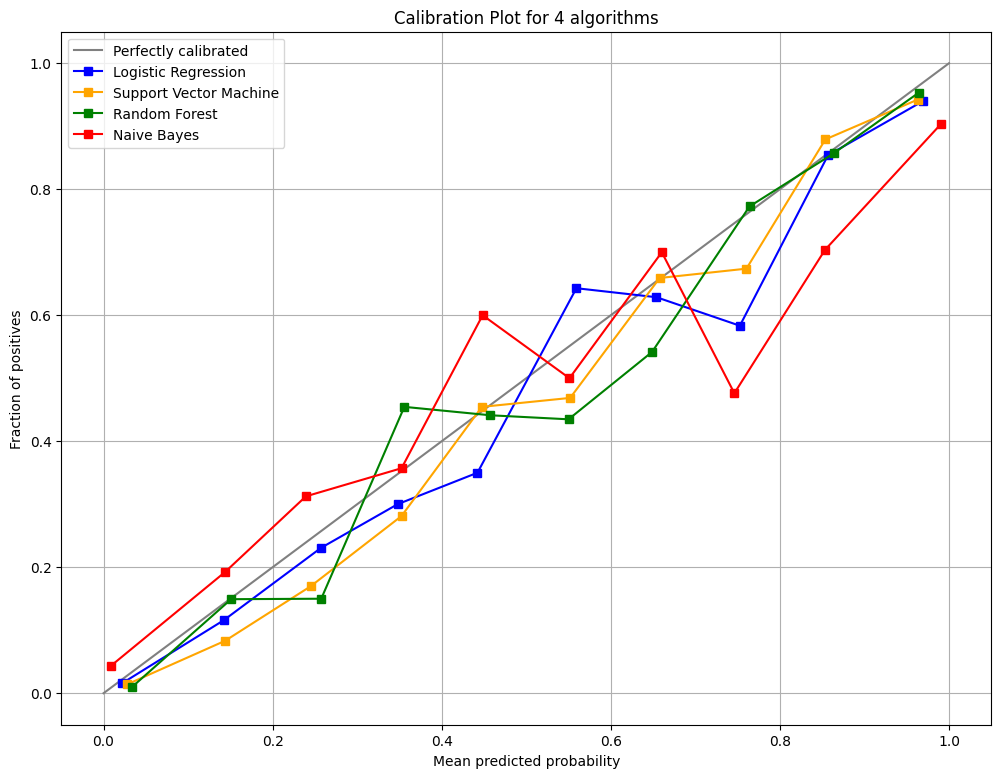

In [1]:
# @title Calibration examples

# Source:
# https://github.com/PacktPublishing/Practical-Guide-to-Applied-Conformal-Prediction/blob/main/Chapter_6_classifier_calibration.ipynb

# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import log_loss, brier_score_loss


# Data Generation
X, y = datasets.make_classification(n_samples=2000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


# Models
models = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(kernel='linear', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

# Training and Predictions
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict_proba(X_test)[:, 1]

# Compute ECE using calibration_curve
def compute_ece(y_true, y_prob, n_bins=10):
    true_frequencies, predicted_probabilities = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    bin_edges = np.linspace(0, 1, n_bins+1)
    bin_width = 1.0 / n_bins
    bin_centers = np.linspace(bin_width/2, 1.0 - bin_width/2, n_bins)
    weights, _ = np.histogram(y_prob, bins=bin_edges, range=(0, 1))
    ece = np.sum(weights * np.abs(predicted_probabilities - bin_centers)) / len(y_prob)
    return ece

# Metrics
results = {
    "Model": [],
    "Log Loss": [],
    "Brier Loss": [],
    "ECE": []
}

for name, preds in predictions.items():
    results["Model"].append(name)
    results["Log Loss"].append(log_loss(y_test, preds))
    results["Brier Loss"].append(brier_score_loss(y_test, preds))
    results["ECE"].append(compute_ece(y_test, preds))

results_df = pd.DataFrame(results)

# Calibration Plot
colors = ['blue', 'orange', 'green', 'red']
plt.figure(figsize=(12, 9))
plt.plot([0, 1], [0, 1], label="Perfectly calibrated", color='gray')
for color, (name, preds) in zip(colors, predictions.items()):
    frac, mean = calibration_curve(y_test, preds, n_bins=10)
    plt.plot(mean, frac, "s-", label=name, color=color)
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Plot for 4 algorithms")
plt.legend()
plt.grid(True)
plt.show()

So if my model is predicting a class with a score of 0.8, but the fraction of positives

# 2. What is conformal prediction



## 2.1 Overview

*   Frequentist approach around hyphotesis testing [[Vovk](https://link.springer.com/book/10.1007/b106715)]
*   Provides error bound on a per-instance basis, no prior probabilities needed (as in Bayesian case)
*   Produces error bounds around predictions
    *    Classifiers: set-valued predictions
    *    Regressors: intervals around predictions

Intuition:

*   Inputs less similar to training data should ead to less certain estimates

## 2.2 Benefits

* Guaranteed coverage: likelihood of predicted region containing true value
* Distribution-free: only assumes data is exchangeable (permuting the data points doesn't change the data distribution)
* Model agnostic: works with classification, regression, CV, NLP, business heuristic
* Fast and easy to compute

**Conformal prediction** can be seen as a method for taking any heuristic notion of
uncertainty from any model and converting it to a rigorous one


## 2.3 Recipe for conformal prediction


1. Choose error rate $\alpha\in (0,1)$ and a calibration set $D_{cal}$.
2. Define a non-conformity score function $s(x, y) \in \mathbb{R}$.
3. Compute the
\begin{equation}
\hat{q} = \frac{\lceil{(n+1)(1-\alpha)}\rceil}{n} \text{ quantile of } \{s_i = s(x_i, y_i) : (x_i,y_i) \in D_{cal}\}
\end{equation}
4. Use this quantile to compute prediction sets for any input $x$:
\begin{equation}
C(x)=\{y: s(x,y)\le\hat{q} \ \}
\end{equation}

### Steps explained

1. Conformal prediction works in the opposite direction of most uncertainty prediction methods. First select the error rate $\alpha\in (0,1)$ depending on the application.  The calibration set $D_{cal}$ is chosen from the data that the model hasn't seen yet.
2. Define a non-conformity score function $s(x, y) \in \mathbb{R}$ that encodes a heuristic notion of uncertainty, where large scores encode worse agreement between $x$ and $y$.
3. The quantile $\hat{q} \ \ $ is essentially the $1-\alpha$ quantile (with a correction for finite sample effect) on these scores and it can be thought as a fair estimate on how the scores translate to uncertainty levels.
4. The extension from point estimation to set estimation $C(x)$ carries naturally a notion of uncertainty. A sample with multiple classes prediction means the classifier has trouble distinguishing between those classes.

## 2.4 Guarantees of conformal prediction


### Coverage

[[Theorem 1](https://arxiv.org/pdf/2107.07511)] For a new prediction $y$ given $x$, we have that
\begin{equation}
 1 - \alpha \le \mathbb{P}[ y \in C(x)] \le  1 - \alpha + \frac{1}{n+1}
\end{equation}
where $n$ is the size of the calibration set, holds for any score function, dataset, $\alpha$, $n$.

Question: *This feels too good to be true. How is it possible to construct valid prediction sets for any given score function?*

Intuition:

*   Assume the scores $s_i$ correctly rank the inputs from lowest to highest model error
*   Then prediction sets $C(x)$ will be smaller for easy inputs and bigger for harder ones   
*   If scores are bad (by not approximating this ranking), then the prediction sets are useless. I.e. random scores will give random prediction sets.
*   The **usefulness** of the prediction set is primarily determined by the **score function**

# 3. Examples

In [3]:
# @title Import libraries and retrieve data

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
!pip install -q -U --no-cache-dir gdown --pre

# Load Imagenet data
if not os.path.exists('../data'):
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz')
    os.system('tar -xf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')
if not os.path.exists('../data/imagenet/human_readable_labels.json'):
    !wget -nv -O ../data/imagenet/human_readable_labels.json -L https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json



In [22]:
# @title Setup variables
num_examples = 10 # @param {type:"integer"}

# Define variables
data = np.load('../data/imagenet/imagenet-resnet152.npz')
example_paths = os.listdir('../data/imagenet/examples')
smx = data['smx']
labels = data['labels'].astype(int)

# Problem setup
n=1000 # number of calibration points
alpha = 0.1 # 1-alpha is the desired coverage

lam_reg = 0.01
k_reg = 5
disallow_zero_sets = False # Set this to False in order to see the coverage upper bound hold
rand = True # Set this to True in order to see the coverage upper bound hold
reg_vec = np.array(k_reg*[0,] + (smx.shape[1]-k_reg)*[lam_reg,])[None,:]

# Split the softmax scores into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = labels[idx], labels[~idx]

# Save some examples to visualise results
with open('../data/imagenet/human_readable_labels.json') as f:
    label_strings = np.array(json.load(f))

example_paths =os.listdir('../data/imagenet/examples')
chosen_paths = []
for i in range(num_examples):
    chosen_paths.append(np.random.choice(example_paths))

### 3.1 Minimal average prediction sets

For a predictor $f$ on Imagenet, we set the conformal score $s_i = 1 - f(X_i)_{Y_i}$ to be one minus the softmax output of the true class $Y_i$.

The score is high when the softmax output of the true class is low, i.e., when the model is badly wrong.

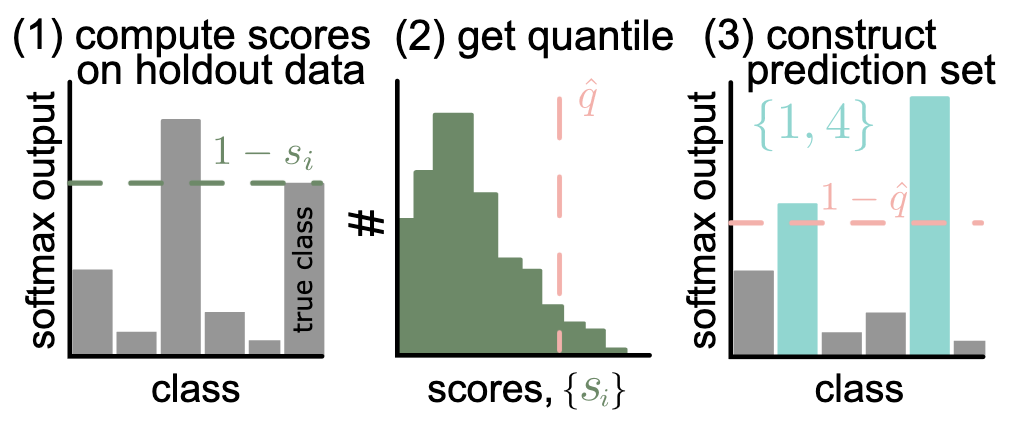


In [23]:
# 1: alpha = 0.1
# 2: Create the conformal score function
# The variable cal_smx is defined in the previous setup
# cal_smx = model(calib_X).softmax(dim=1).numpy()
cal_scores = 1-cal_smx[np.arange(n),cal_labels]

# 3: get adjusted quantile
q_level = np.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(cal_scores, q_level, interpolation='higher')

# 4: form prediction sets
prediction_sets = val_smx >= (1-qhat)

In [24]:
# Calculate empirical coverage
empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]),val_labels].mean()
print(f"The empirical coverage is: {empirical_coverage}")

The empirical coverage is: 0.8892040816326531


In [ ]:
# Show the examples
pred_set_min_avg =[]
for img_path in chosen_paths:
    img = imread('../data/imagenet/examples/' + img_path )
    img_index = int(img_path.split('.')[0])
    prediction_set = smx[img_index] > 1-qhat
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    pred_set_str = list(label_strings[prediction_set])
    print(f"The prediction set is: {pred_set_str}")
    pred_set_min_avg.append(pred_set_str)

Remarks:

*   Tends to undercover hard subgroups
*   Tends to overcover easy subgroups
*   Produces the prediction sets with the smallest average size

## 3.2 Adaptative Prediction sets

Let's improve the previous attempt (see [[2.1](https://arxiv.org/pdf/2107.07511)]) by greedily selecting the top clases of the softmax outpus of $f(x)$ until the total probability mass exceeds $1-\alpha$.

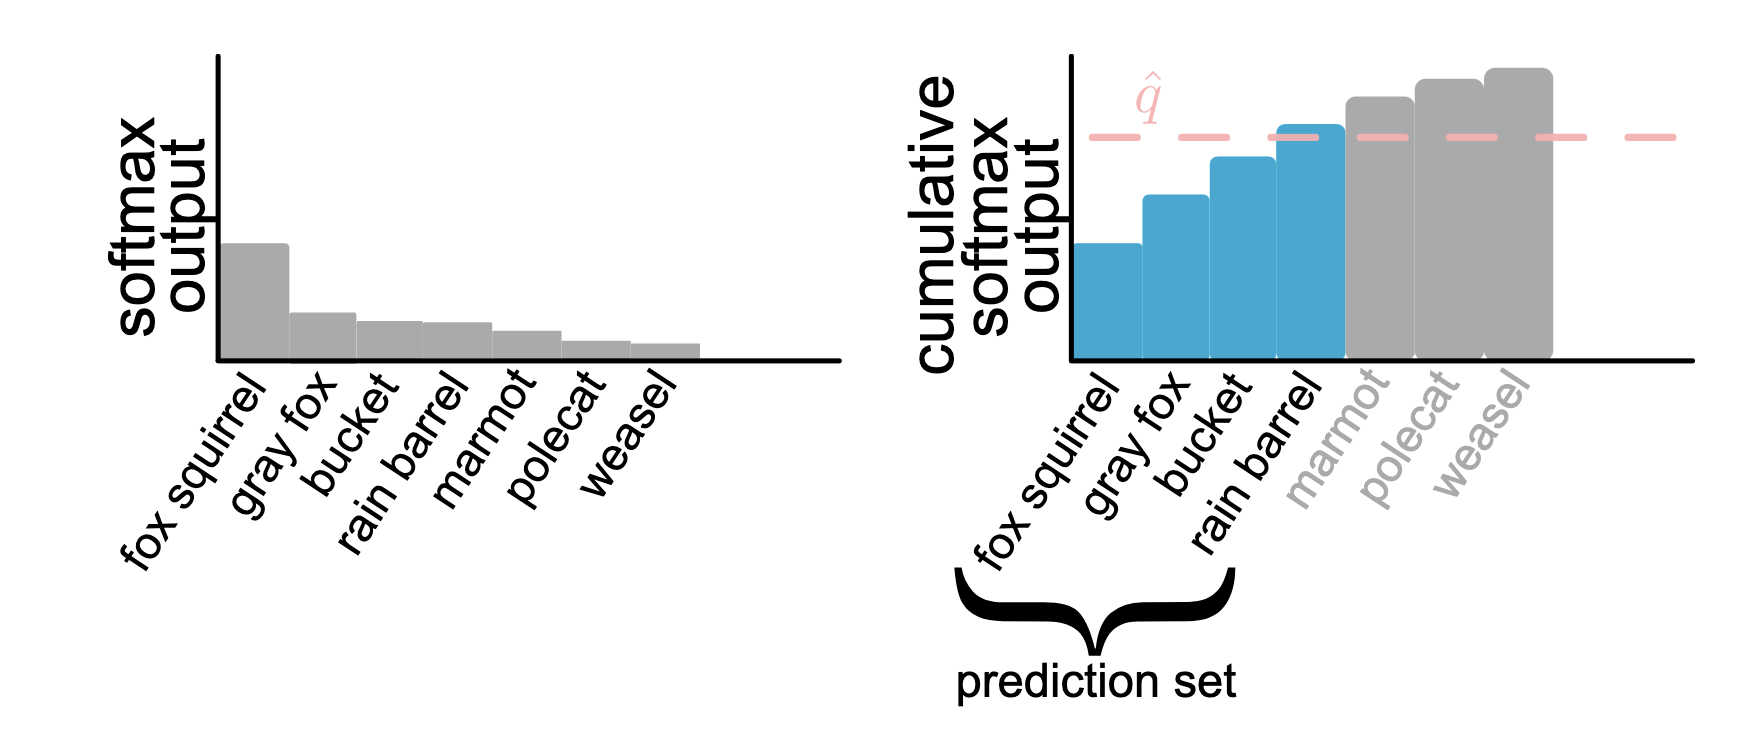

In [26]:
# 1: alpha = 0.1
# 2: Create the conformal score function
# Get scores. calib_X.shape[0] == calib_Y.shape[0] == n
cal_pi = cal_smx.argsort(1)[:,::-1];
cal_srt = np.take_along_axis(cal_smx,cal_pi,axis=1)
cal_srt_reg = cal_srt + reg_vec
cal_L = np.where(cal_pi == cal_labels[:,None])[1]
cal_scores = cal_srt_reg.cumsum(axis=1)[np.arange(n),cal_L] - np.random.rand(n)*cal_srt_reg[np.arange(n),cal_L]

# 3: Get the score quantile
qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')

# 4: Deploy prediction sets
n_val = val_smx.shape[0]
val_pi = val_smx.argsort(1)[:,::-1]
val_srt = np.take_along_axis(val_smx,val_pi,axis=1)
val_srt_reg = val_srt + reg_vec
val_srt_reg_cumsum = val_srt_reg.cumsum(axis=1)
indicators = (val_srt_reg.cumsum(axis=1) - np.random.rand(n_val,1)*val_srt_reg) <= qhat if rand else val_srt_reg.cumsum(axis=1) - val_srt_reg <= qhat
if disallow_zero_sets: indicators[:,0] = True
prediction_sets = np.take_along_axis(indicators,val_pi.argsort(axis=1),axis=1)

In [27]:
# Calculate empirical coverage
empirical_coverage = prediction_sets[np.arange(n_val),val_labels].mean()
print(f"The empirical coverage is: {empirical_coverage}")
print(f"The quantile is: {qhat}")

The empirical coverage is: 0.8939387755102041
The quantile is: 0.9438609617418484


In [ ]:
pred_set_aps = []
for img_path in chosen_paths:
    img = imread('../data/imagenet/examples/' + img_path )
    img_index = int(img_path.split('.')[0])
    # Form the prediction set
    _smx = smx[img_index]
    _pi = np.argsort(_smx)[::-1]
    _srt = np.take_along_axis(_smx,_pi,axis=0)
    _srt_reg = _srt + reg_vec.squeeze()
    _srt_reg_cumsum = _srt_reg.cumsum()
    _ind = (_srt_reg_cumsum - np.random.rand()*_srt_reg) <= qhat if rand else _srt_reg_cumsum - _srt_reg <= qhat
    if disallow_zero_sets: _ind[0] = True
    prediction_set = np.take_along_axis(_ind,_pi.argsort(),axis=0)
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    pred_set_str = list(label_strings[prediction_set])
    print(f"The prediction set is: {pred_set_str}")
    pred_set_aps.append(pred_set_str)

Let's compare the results in a more user friendly way:

In [ ]:
for a,b,c in zip(pred_set_min_avg,pred_set_aps,chosen_paths):
    img = imread('../data/imagenet/examples/' + c )
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"min_avg:\t{a} \naps: \t\t{b}\n\n")

# References

1.   [Measuring Models' Uncertainty: Conformal Prediction](https://blog.dataiku.com/measuring-models-uncertainty-conformal-prediction), Leo Dreyfus-Schmidt
2.   [A Gentle Introduction to Conformal Prediction and
Distribution-Free Uncertainty Quantification](https://arxiv.org/pdf/2107.07511), Anastasios N. Angelopoulos and Stephen Bates
3.   [Conformal Prediction Github Repository](https://github.com/aangelopoulos/conformal-prediction)
4.   [Practical Guide to Applied Conformal Prediction in Python](https://learning.oreilly.com/library/view/practical-guide-to/9781805122760/), Valery Manokhin
5.   Mapie
6.   Crepes
7.   [A tutorial on Conformal prediction](https://www.youtube.com/watch?v=nql000Lu_iE)



